# Задача классификации. Метод ближайших соседей (kNN)

In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

## Предсказание ортопедических проблем по измерениям костей таза и нижнего позвоночника. 

Данные взяты с https://www.kaggle.com/uciml/biomechanical-features-of-orthopedic-patients#_=

In [2]:
df = pd.read_csv('column_2C_weka.csv')

In [3]:
df.head()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
pelvic_incidence            310 non-null float64
pelvic_tilt numeric         310 non-null float64
lumbar_lordosis_angle       310 non-null float64
sacral_slope                310 non-null float64
pelvic_radius               310 non-null float64
degree_spondylolisthesis    310 non-null float64
class                       310 non-null object
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


In [8]:
df.isnull().sum()

pelvic_incidence            0
pelvic_tilt numeric         0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
class                       0
dtype: int64

## Распределение целевой переменной

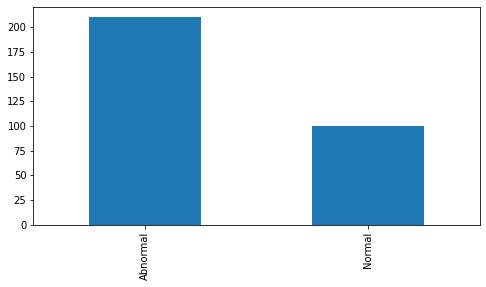

In [11]:
df['class'].value_counts().plot.bar(figsize=(8, 4))

In [12]:
df['class'].value_counts(normalize=True)

Abnormal    0.677419
Normal      0.322581
Name: class, dtype: float64

Можно прикинуть наш baseline качества, с которым можно будет сравнивать результаты работы модели. Если у нас 68% одного класса и 32% другого, то даже если наша модель будет предсказывать сплошные Abnormal, то accuracy будет равна, в среднем, 68%.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BA4C208>,
      dtype=object)

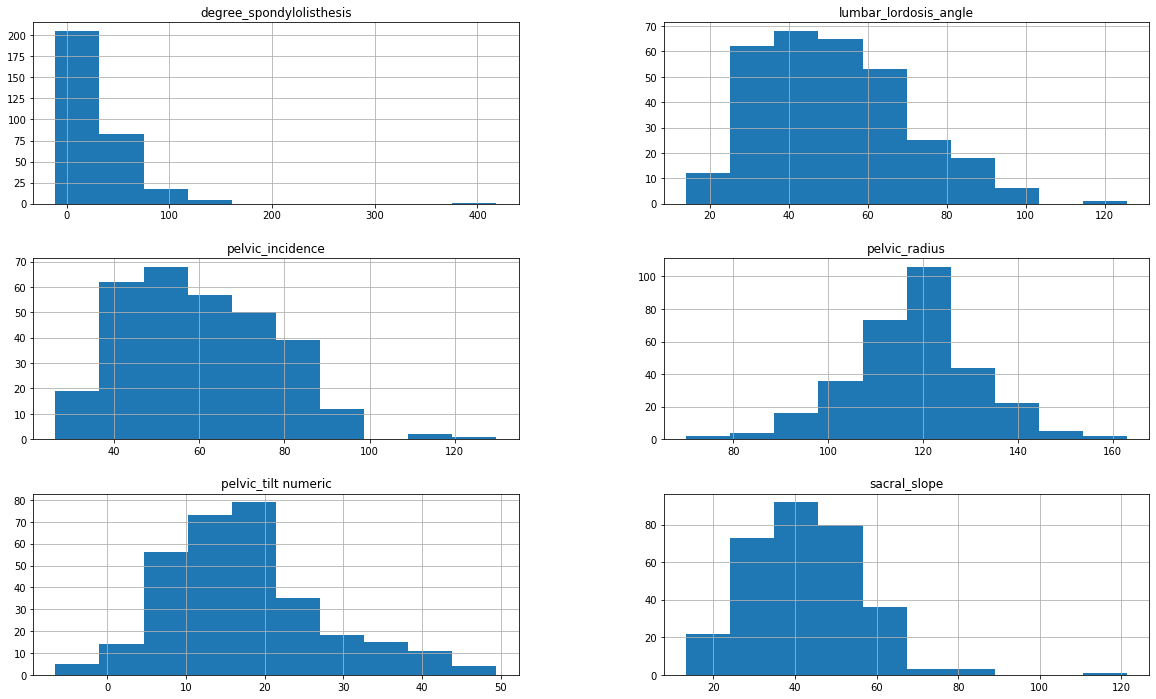

In [15]:
df.hist(figsize=(20, 12))

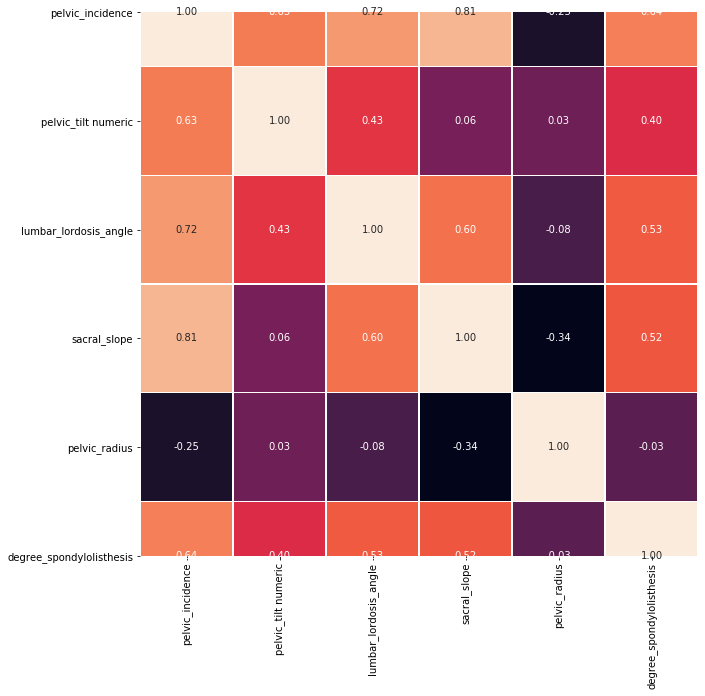

In [16]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

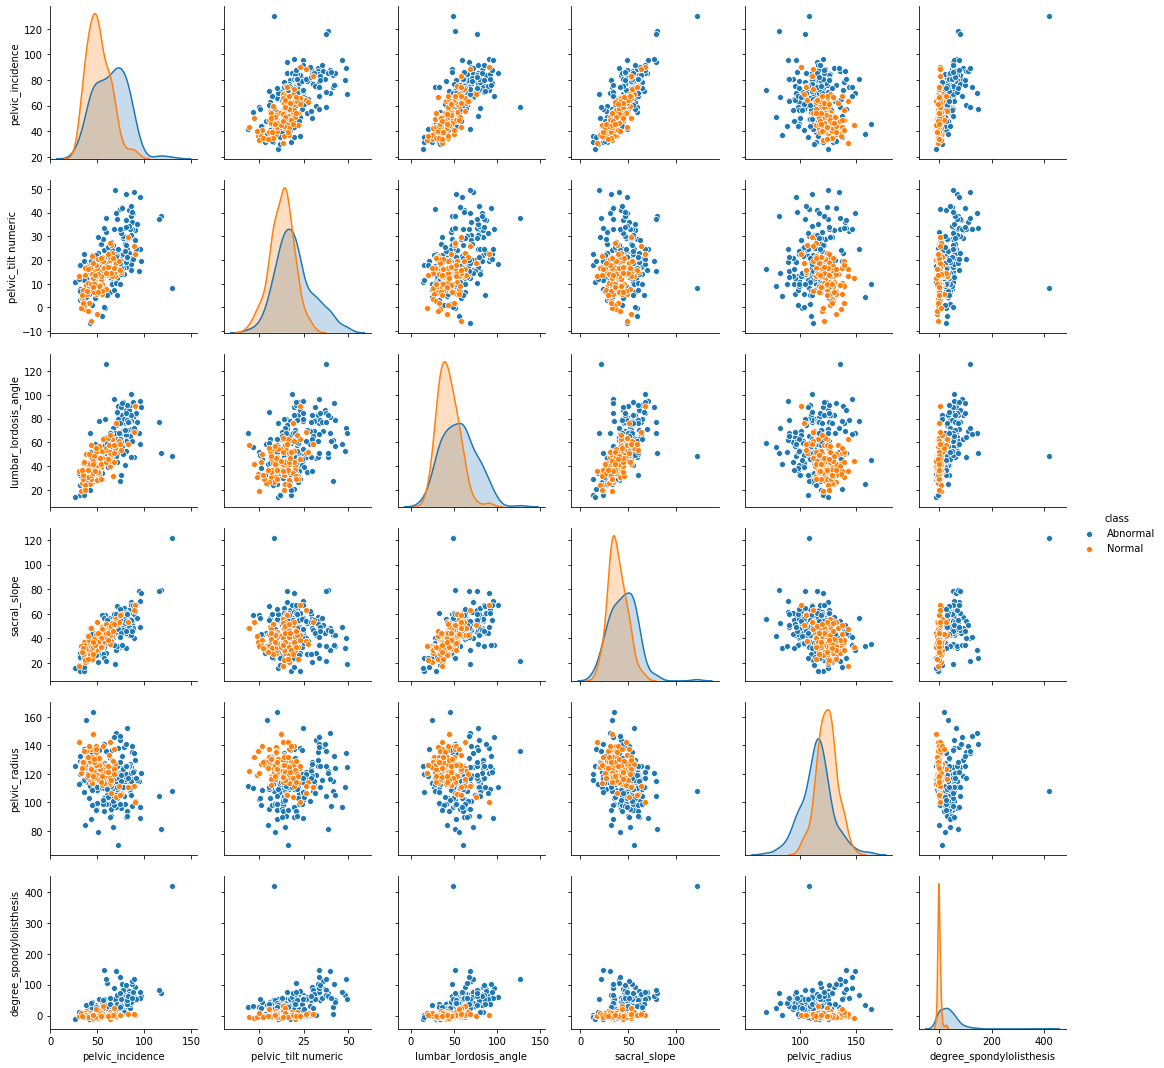

In [17]:
sns.pairplot(df, hue='class')

## Перекодируем целевую

In [20]:
df['class'] = df['class'].apply(lambda x: 1 if x=='Abnormal' else 0)

In [21]:
df.head()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,1


## Train-test split

Параметр stratify позволит создавать такие разбиения, в которых распределения указанной переменной будут сохраняться. Очень полезно при дисбалансе классов.

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['class'], axis=1), df['class'], test_size=0.20, random_state=42, stratify=df['class']
)

In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((248, 6), (62, 6), (248,), (62,))

In [26]:
y_train.value_counts(normalize=True)

1    0.677419
0    0.322581
Name: class, dtype: float64

In [27]:
y_test.value_counts(normalize=True)

1    0.677419
0    0.322581
Name: class, dtype: float64

Пропорция в классах сохранилась

## Scaling

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Подбор параметров разными способами

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

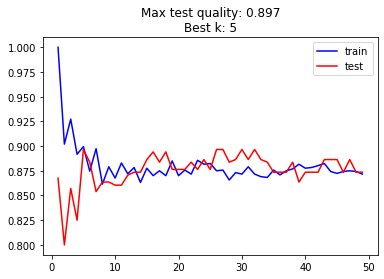

In [32]:
neighbors = range(1, 50)
f1_score_train = []
f1_score_test = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    f1_score_train.append(f1_score(knn.predict(X_train_scaled), y_train))
    f1_score_test.append(f1_score(knn.predict(X_test_scaled), y_test))
    
plt.plot(neighbors, f1_score_train, color='blue', label='train')
plt.plot(neighbors, f1_score_test, color='red', label='test')
plt.title("Max test quality: {:.3f}\nBest k: {}".format(max(f1_score_test), np.argmax(f1_score_test)+1))
plt.legend()

## GridSearchCV

In [33]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
        'n_neighbors': range(1, 50),
        'p': range(1, 4)
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_scaled, y_train)

print("Best CV score: {:.3f}, best CV k: {}".format(
    grid_search.best_score_, grid_search.best_estimator_.n_neighbors)
) 


test_predictions = grid_search.best_estimator_.predict(X_test_scaled)
print("Resulting test score: {:.3f}".format(f1_score(test_predictions, y_test)))

Best CV score: 0.885, best CV k: 33
Resulting test score: 0.886
Wall time: 6.2 s
